#### Faster computation of sonic pressure if specified boundary pressure corresponds to supersonic flow

In [1]:
# Config
import copy
import os
import numpy as np
from numpy.linalg import norm
import matplotlib
import matplotlib.pyplot as plt

# Path for ffmpeg (if animations are needed)
plt.rcParams['animation.ffmpeg_path'] = "C:\\Users\\Fredric\\Documents\\ffmpeg\\ffmpeg-n4.4-latest-win64-gpl-4.4\\bin\\ffmpeg.exe"

# Path for .pkl files output
# target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\tungurahua\\"
target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\test_oscillations\\"
# target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\results_dx4m\\"

# Path for Quail source code
source_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\src\\"

# Path for Quail entry point
quail_path = os.path.join(source_dir, "quail")

# Name of file to run (must be located in target_dir)
target_file = "conduit_p.py"

In [2]:
%load_ext autoreload
%autoreload 2

# Import quail modules
os.chdir(source_dir)
import argparse
import importlib
import sys
import scipy

import defaultparams as default_deck
import errors
from general import ShapeType, SolverType, PhysicsType

import meshing.common as mesh_common
import meshing.gmsh as mesh_gmsh
import meshing.tools as mesh_tools

import numerics.helpers.helpers as helpers
import numerics.timestepping.tools as stepper_tools

import physics.zerodimensional.zerodimensional as zerod
import physics.euler.euler as euler
import physics.navierstokes.navierstokes as navierstokes
import physics.scalar.scalar as scalar
import physics.chemistry.chemistry as chemistry
import physics.multiphasevpT.multiphasevpT as multiphasevpT

import processing.readwritedatafiles as readwritedatafiles
import processing.post as post
import processing.plot as plot
import processing
import processing.mdtools as mdtools

import solver.DG as DG
import solver.ADERDG as ADERDG
import solver.tools as solver_tools

import time
import multiprocessing as mp
from multidomain import Domain, Observer

os.chdir(target_dir)

In [36]:
''' Attach some Quail output for suitable data input shapes. '''
solver1D_par = lambda solver_idx, i: readwritedatafiles.read_data_file(
  #f"featuretest_conduit1_{i}.pkl")
  f"oscillationtest_conduit1_BCIC_4s_par_sub{solver_idx}_{i}.pkl")
solver = solver1D_par(4,1)


In [37]:
# Simulate input
self = type("StandinClass", (object,), {"p": 1e5})
physics = solver.physics
UqI = solver.state_coeffs[-1:,-1:,:]
normals = np.array([[[1.0]]])
x = normals.copy()
t = 0.0

In [38]:
import physics.multiphasevpT.atomics as atomics
import scipy.optimize

In [200]:
def classical_rootfinding(self, UqI, normals, x, t, is_handling_choking=True):
  UqB = UqI.copy()
  ''' Compute normal velocity. '''
  arhoVec = UqI[:,:,physics.get_mass_slice()]
  rhoI = atomics.rho(arhoVec)
  velI = UqI[:, :, physics.get_momentum_slice()]/rhoI

  ''' Compute interior pressure. '''
  TI = atomics.temperature(arhoVec,
    UqI[:,:,physics.get_momentum_slice()], 
    UqI[:,:,physics.get_state_slice("Energy")], physics)
  gas_volfrac = atomics.gas_volfrac(arhoVec, TI, physics)
  pI = atomics.pressure(arhoVec, TI, gas_volfrac, physics)
  if np.any(pI < 0.):
    raise errors.NotPhysicalError
  # Compute mass-weighted quantities
  Gamma = atomics.Gamma(arhoVec, physics)
  yI = atomics.massfrac(arhoVec)

  ''' Short-circuit function for sonic exit based on interior '''
  cI = atomics.sound_speed(Gamma, pI, rhoI, gas_volfrac, physics)
  if np.any(velI >= cI):
    return UqB
  elif np.any(velI < 0):
    raise ValueError("Inflow")

  ''' Compute boundary-satisfying primitive state that preserves Riemann
  invariants (corresponding to ingoing acoustic waves) of the interior
  solution. '''
  p_target = self.p
  _, u_target, T_target = atomics.velocity_RI_fixed_p_quadrature(
    p_target, UqB, physics, normals, is_adaptive=True)

  def constrained_sound_speed(p_target):
    T_target = TI * (p_target / pI) ** ((Gamma-1)/Gamma)
    rho = atomics.mixture_density(yI, p_target, T_target, physics)
    return atomics.sound_speed(Gamma,
      p_target, rho,
      atomics.gas_volfrac(rho*yI, T_target, physics), physics)
      
  def mach_residual(p):
    ''' Residual in equation c - u = 0''' 
    return constrained_sound_speed(p) - \
      atomics.velocity_RI_fixed_p_quadrature(
        p, UqB, physics, normals, is_adaptive=True)[1] # Velocity
  
  if is_handling_choking:
    ''' Recompute sonic pressure for supersonic boundary state. '''
    if np.any(u_target > constrained_sound_speed(p_target)):
      # Recompute based on sonic pressure
      # TODO: Clean up
      pSonic = scipy.optimize.brenth(mach_residual, p_target, pI)
      _, u_target, T_target = atomics.velocity_RI_fixed_p_quadrature(
        pSonic, UqB, physics, normals, is_adaptive=True)
      p_target = pSonic

  ''' Map to conservative variables '''
  rho_target = atomics.mixture_density(yI, p_target, T_target, physics)
  UqB[:,:,physics.get_mass_slice()] = rho_target * yI
  UqB[:,:,physics.get_momentum_slice()] = rho_target * u_target
  UqB[:,:,physics.get_state_slice("Energy")] = \
    atomics.c_v(rho_target * yI, physics) * T_target \
    + (rho_target * yI[:,:,2:3]) * physics.Liquid["E_m0"] \
    + 0.5 * rho_target * u_target * u_target
  ''' Update adiabatically compressed/expanded tracer partial densities '''
  UqB[:,:,5:] *= rho_target / rhoI

  ''' Post-computation validity check '''
  if np.any(T_target < 0.):
    raise errors.NotPhysicalError

  return UqB

N_timing = 500
t1 = time.perf_counter()
for i in range(N_timing):
  Uout = classical_rootfinding(self, UqI, normals, x, t, is_handling_choking=False)
wall_clock = (time.perf_counter() - t1)/N_timing
print("=== Classical, without choked flow handling: ")
print(f"U = {Uout}")
print(f"\x1b[32mWall t\x1b[0m = {wall_clock*1e3} ms")
print(f"p = {physics.compute_additional_variable('Pressure', Uout, False)}")
print(f"u = {physics.compute_additional_variable('XVelocity', Uout, False)}")

t1 = time.perf_counter()
for i in range(N_timing):
  Uout = classical_rootfinding(self, UqI, normals, x, t, is_handling_choking=True)
wall_clock = (time.perf_counter() - t1)/N_timing
print("=== Classical, with choked flow handling: ")
print(f"U = {Uout}")
print(f"\x1b[32mWall t\x1b[0m = {wall_clock*1e3} ms")
print(f"p = {physics.compute_additional_variable('Pressure', Uout, False)}")
print(f"u = {physics.compute_additional_variable('XVelocity', Uout, False)}")

=== Classical, without choked flow handling: 
U = [[[1.110389992953475e-06 2.176712647410851e-01 1.088622755440365e+01
   1.305020883637493e+03 3.285910068841342e+07 3.192404259760995e-01
   4.469319721637715e+00 5.877664178278679e+00]]]
Wall t = 0.420492799996282 ms
p = [[[99999.99999983609]]]
u = [[[117.52815604599705]]]
=== Classical, with choked flow handling: 
U = [[[1.401066057405758e-06 2.746528900986730e-01 1.373600628289282e+01
   1.336201871820033e+03 4.145721982440692e+07 4.028106591605508e-01
   5.639290881058149e+00 7.416309431168485e+00]]]
Wall t = 2.82624080000096 ms
p = [[[126401.42706337571]]]
u = [[[95.3703692097269]]]


In [199]:
def ivp_rootfinding(self, UqI, normals, x, t, is_handling_choking=True, get_soln_obj=False):
  UqB = UqI.copy()
  ''' Compute normal velocity. '''
  arhoVec = UqI[:,:,physics.get_mass_slice()]
  rhoI = atomics.rho(arhoVec)
  velI = UqI[:, :, physics.get_momentum_slice()]/rhoI

  ''' Compute interior pressure. '''
  TI = atomics.temperature(arhoVec,
    UqI[:,:,physics.get_momentum_slice()], 
    UqI[:,:,physics.get_state_slice("Energy")], physics)
  gas_volfrac = atomics.gas_volfrac(arhoVec, TI, physics)
  pI = atomics.pressure(arhoVec, TI, gas_volfrac, physics)
  if np.any(pI < 0.):
    raise errors.NotPhysicalError
  # Compute mass-weighted quantities
  Gamma = atomics.Gamma(arhoVec, physics)
  yI = atomics.massfrac(arhoVec)

  ''' Short-circuit function for sonic exit based on interior '''
  cI = atomics.sound_speed(Gamma, pI, rhoI, gas_volfrac, physics)
  if np.any(velI >= cI):
    return UqB
  elif np.any(velI < 0):
    raise ValueError("Inflow")

  ''' Compute boundary-satisfying primitive state that preserves Riemann
  invariants (corresponding to ingoing acoustic waves) of the interior
  solution. '''
  # p_target = self.p
  # _, u_target, T_target = atomics.velocity_RI_fixed_p_quadrature(
  #   p_target, UqB, physics, normals, is_adaptive=True)

  # Reformat initial conditions in state space
  T1, p1, u1 = TI.ravel()[0], pI.ravel()[0], np.array([velI.ravel()[0],])
  p2 = self.p

  # Define affine mapping from progress variable t to pressure p
  t2p = lambda t: p1 + t*(p2-p1)

  # Locally define acoustic admittance integrand for speed
  am2 = physics.Liquid["K"] / physics.Liquid["rho0"]
  # Gas mole fraction (mole-weighted for each gas)
  yR_g = yI[...,0].squeeze() * physics.Gas[0]["R"] \
    + yI[...,1].squeeze() * physics.Gas[1]["R"]
  yM = yI[...,2].squeeze()
  p_intercept = physics.Liquid["p0"] - physics.Liquid["K"]

  def Y_s(p):
    '''Isentropic admittance function'''
    rhom_am2 = p - p_intercept
    return np.sqrt((
      yR_g * T1 * (p/p1)**((Gamma-1.0)/Gamma) / (p*p)
      + yM * am2 / (rhom_am2*rhom_am2)
    ) / Gamma)
  
  class ChokingEvent():
    ''' Initial value problem termination event, returning u - c. '''
    def __init__(self):
      self.terminal = True

    def __call__(self, t, u):
      # Map progress variable t to pressure p
      p = t2p(t)
      # Compute temperature along isentrope
      T = T1 * (p / p1) **((Gamma-1.0)/Gamma)
      # Compute mixture density
      rho = atomics.mixture_density(yI, p, T, physics)
      # Return u - c
      return u - atomics.sound_speed(Gamma, p, rho,
        atomics.gas_volfrac(rho*yI, TI, physics), physics).ravel()[0]
  
  # Solve IVP for progress variable on [0,1], checking for choking, and 
  #   defaulting to one-step if possible
  soln_obj = scipy.integrate.solve_ivp(
    lambda t, u:
      -normals * (p2-p1) * Y_s(t2p(t)),
    (0, 1), u1, vectorized=True, first_step=1.0, events=[ChokingEvent()])
  # Check for choking
  if len(soln_obj.y_events[0]) == 0:
    # Extract velocity at target pressure
    u_target = soln_obj.y.ravel()[-1]
  else:
    # Extract velocity at choking
    u_target = soln_obj.y_events[0][0]
    # Re-evaluate target pressure
    p2 = t2p(soln_obj.t_events[0][0])

  # Compute temperature along isentrope
  T_target = T1 * (p2 / p1) **((Gamma-1.0)/Gamma)

  ''' Map to conservative variables '''
  rho_target = atomics.mixture_density(yI, p2, T_target, physics)
  UqB[:,:,physics.get_mass_slice()] = rho_target * yI
  UqB[:,:,physics.get_momentum_slice()] = rho_target * u_target
  UqB[:,:,physics.get_state_slice("Energy")] = \
    atomics.c_v(rho_target * yI, physics) * T_target \
    + (rho_target * yI[:,:,2:3]) * physics.Liquid["E_m0"] \
    + 0.5 * rho_target * u_target * u_target
  ''' Update adiabatically compressed/expanded tracer partial densities '''
  UqB[:,:,5:] *= rho_target / rhoI

  ''' Post-computation validity check '''
  if np.any(T_target < 0.):
    raise errors.NotPhysicalError

  if get_soln_obj:
    return UqB, soln_obj
  return UqB

N_timing = 500
t1 = time.perf_counter()
for i in range(N_timing):
  Uout = ivp_rootfinding(self, UqI, normals, x, t, is_handling_choking=False)
wall_clock = (time.perf_counter() - t1)/N_timing
print("=== IVP-based, without choked flow handling: ")
print(f"U = {Uout}")
print(f"\x1b[32mWall t\x1b[0m = {wall_clock*1e3} ms")
print(f"p = {physics.compute_additional_variable('Pressure', Uout, False)}")
print(f"u = {physics.compute_additional_variable('XVelocity', Uout, False)}")

# t1 = time.perf_counter()
# for i in range(N_timing):
#   Uout = classical_rootfinding(self, UqI, normals, x, t, is_handling_choking=True)
# wall_clock = (time.perf_counter() - t1)/N_timing
# print("=== Classical, with choked flow handling: ")
# print(f"U = {Uout}")
# print(f"\x1b[32mWall t\x1b[0m = {wall_clock*1e3} ms")
# print(f"p = {physics.compute_additional_variable('Pressure', Uout, False)}")
# print(f"u = {physics.compute_additional_variable('XVelocity', Uout, False)}")

=== IVP-based, without choked flow handling: 
U = [[[1.399364490245420e-06 2.743193295675236e-01 1.371932417352216e+01
   1.334568312905787e+03 4.140671640164762e+07 4.023214535404170e-01
   5.632442073237789e+00 7.407302469282373e+00]]]
Wall t = 1.023553400002129 ms
p = [[[126246.66214863956]]]
u = [[[95.36959971534885]]]


In [210]:
np.any(1 < 0)

False

In [209]:
# %%prun
def ivp_rootfinding(self, UqI, normals, x, t, is_handling_choking=True, get_soln_obj=False):
  UqB = UqI.copy()
  ''' Compute normal velocity. '''
  arhoVec = UqI[:,:,physics.get_mass_slice()]
  rhoI = atomics.rho(arhoVec)
  velI = UqI[:, :, physics.get_momentum_slice()]/rhoI

  ''' Compute interior pressure. '''
  TI = atomics.temperature(arhoVec,
    UqI[:,:,physics.get_momentum_slice()], 
    UqI[:,:,physics.get_state_slice("Energy")], physics)
  gas_volfrac = atomics.gas_volfrac(arhoVec, TI, physics)
  pI = atomics.pressure(arhoVec, TI, gas_volfrac, physics)
  if np.any(pI < 0.):
    raise errors.NotPhysicalError
  # Compute mass-weighted quantities
  Gamma = atomics.Gamma(arhoVec, physics)
  yI = atomics.massfrac(arhoVec)

  ''' Short-circuit function for sonic exit based on interior '''
  cI = atomics.sound_speed(Gamma, pI, rhoI, gas_volfrac, physics)
  if np.any(velI >= cI):
    return UqB
  elif np.any(velI < 0):
    raise ValueError("Inflow")

  ''' Compute boundary-satisfying primitive state that preserves Riemann
  invariants (corresponding to ingoing acoustic waves) of the interior
  solution. '''
  # p_target = self.p
  # _, u_target, T_target = atomics.velocity_RI_fixed_p_quadrature(
  #   p_target, UqB, physics, normals, is_adaptive=True)

  # Reformat initial conditions in state space
  T1, p1, u1 = TI.ravel()[0], pI.ravel()[0], np.array([velI.ravel()[0],])
  p2 = self.p

  # Define affine mapping from progress variable t to pressure p
  t2p = lambda t: p1 + t*(p2-p1)

  # Locally define acoustic admittance integrand for speed
  am2 = physics.Liquid["K"] / physics.Liquid["rho0"]
  # Gas mole fraction (mole-weighted for each gas)
  yR_g = yI[...,0].squeeze() * physics.Gas[0]["R"] \
    + yI[...,1].squeeze() * physics.Gas[1]["R"]
  yM = yI[...,2].squeeze()
  p_intercept = physics.Liquid["p0"] - physics.Liquid["K"]

  def Y_s(p):
    '''Isentropic admittance function'''
    rhom_am2 = p - p_intercept
    return np.sqrt((
      yR_g * T1 * (p/p1)**((Gamma-1.0)/Gamma) / (p*p)
      + yM * am2 / (rhom_am2*rhom_am2)
    ) / Gamma)
  
  class ChokingEvent():
    ''' Initial value problem termination event, returning u - c. '''
    def __init__(self):
      self.terminal = True

    def __call__(self, t, u):
      # Map progress variable t to pressure p
      p = t2p(t)
      # Compute temperature along isentrope
      T = T1 * (p / p1) **((Gamma-1.0)/Gamma)
      # Compute mixture density
      rho = atomics.mixture_density(yI, p, T, physics)
      # Return u - c
      return u - atomics.sound_speed(Gamma, p, rho,
        atomics.gas_volfrac(rho*yI, TI, physics), physics).ravel()[0]
  
  # Solve IVP for progress variable on [0,1], checking for choking, and 
  #   defaulting to one-step if possible
  soln_obj = scipy.integrate.solve_ivp(
    lambda t, u:
      -normals * (p2-p1) * Y_s(t2p(t)),
    (0, 1), u1, vectorized=True, first_step=1.0, events=[ChokingEvent()])
  # Check for choking
  if len(soln_obj.y_events[0]) == 0:
    # Extract velocity at target pressure
    u_target = soln_obj.y.ravel()[-1]
  else:
    # Extract velocity at choking
    u_target = soln_obj.y_events[0][0]
    # Re-evaluate target pressure
    p2 = t2p(soln_obj.t_events[0][0])

  # Compute temperature along isentrope
  T_target = T1 * (p2 / p1) **((Gamma-1.0)/Gamma)

  ''' Map to conservative variables '''
  rho_target = atomics.mixture_density(yI, p2, T_target, physics)
  UqB[:,:,physics.get_mass_slice()] = rho_target * yI
  UqB[:,:,physics.get_momentum_slice()] = rho_target * u_target
  UqB[:,:,physics.get_state_slice("Energy")] = \
    atomics.c_v(rho_target * yI, physics) * T_target \
    + (rho_target * yI[:,:,2:3]) * physics.Liquid["E_m0"] \
    + 0.5 * rho_target * u_target * u_target
  ''' Update adiabatically compressed/expanded tracer partial densities '''
  UqB[:,:,5:] *= rho_target / rhoI

  ''' Post-computation validity check '''
  if np.any(T_target < 0.):
    raise errors.NotPhysicalError

  if get_soln_obj:
    return UqB, soln_obj
  return UqB

N_timing = 500
t1 = time.perf_counter()
for i in range(N_timing):
  Uout = ivp_rootfinding(self, UqI, normals, x, t, is_handling_choking=False)
wall_clock = (time.perf_counter() - t1)/N_timing
print("=== IVP-based, without choked flow handling: ")
print(f"U = {Uout}")
print(f"\x1b[32mWall t\x1b[0m = {wall_clock*1e3} ms")
print(f"p = {physics.compute_additional_variable('Pressure', Uout, False)}")
print(f"u = {physics.compute_additional_variable('XVelocity', Uout, False)}")

# t1 = time.perf_counter()
# for i in range(N_timing):
#   Uout = classical_rootfinding(self, UqI, normals, x, t, is_handling_choking=True)
# wall_clock = (time.perf_counter() - t1)/N_timing
# print("=== Classical, with choked flow handling: ")
# print(f"U = {Uout}")
# print(f"\x1b[32mWall t\x1b[0m = {wall_clock*1e3} ms")
# print(f"p = {physics.compute_additional_variable('Pressure', Uout, False)}")
# print(f"u = {physics.compute_additional_variable('XVelocity', Uout, False)}")

=== IVP-based, without choked flow handling: 
U = [[[1.399364490245420e-06 2.743193295675236e-01 1.371932417352216e+01
   1.334568312905787e+03 4.140671640164762e+07 4.023214535404170e-01
   5.632442073237789e+00 7.407302469282373e+00]]]
Wall t = 1.3269518000015523 ms
p = [[[126246.66214863956]]]
u = [[[95.36959971534885]]]
 

         391158 function calls (389642 primitive calls) in 0.665 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     6000    0.062    0.000    0.062    0.000 atomics.py:55(gas_volfrac)
     5500    0.058    0.000    0.204    0.000 <string>:62(__call__)
     6000    0.048    0.000    0.048    0.000 atomics.py:39(mixture_spec_vol)
     5500    0.039    0.000    0.132    0.000 rk.py:546(_call_impl)
     6000    0.037    0.000    0.037    0.000 atomics.py:119(sound_speed)
     3500    0.036    0.000    0.036    0.000 <string>:49(Y_s)
      500    0.033    0.000    0.662    0.001 <string>:1(ivp_rootfinding)
31007/29507    0.029    0.000    0.147    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
     5500    0.027    0.000    0.048    0.000 shape_base.py:1171(tile)
    20503    0.020    0.000    0.020    0.000 {built-in method numpy.array}
     7007    0.020    0.000    0.020    0.000 {method 'redu

In [144]:
# Reformat initial conditions in state space
T1, p1, u1 = TI.ravel()[0], pI.ravel()[0], np.array([velI.ravel()[0],])
p2 = self.p

# Define affine mapping from progress variable t to pressure p
t2p = lambda t: p1 + t *(p2-p1)

# Locally define acoustic admittance integrand for speed
am2 = physics.Liquid["K"] / physics.Liquid["rho0"]
# Gas mole fraction (mole-weighted for each gas)
yR_g = yI[...,0].squeeze() * physics.Gas[0]["R"] \
  + yI[...,1].squeeze() * physics.Gas[1]["R"]
yM = yI[...,2].squeeze()
p_intercept = physics.Liquid["p0"] - physics.Liquid["K"]
def Y_s(p):
  rhom_am2 = p - p_intercept
  return np.sqrt((
    yR_g * T1 * (p/p1)**((Gamma-1.0)/Gamma) / (p*p)
    + yM * am2 / (rhom_am2*rhom_am2)
  ) / Gamma)
soln_obj = scipy.integrate.solve_ivp(
  lambda t, u:
    -normals * (p2-p1) * Y_s(t2p(t)),
  (0, 1), u1, vectorized=True, first_step=1.0)

In [168]:
# Sound speed along an isentrope
arhoVec = UqI[:,:,physics.get_mass_slice()]
rhoI = atomics.rho(arhoVec)
velI = UqI[:, :, physics.get_momentum_slice()]/rhoI

''' Compute interior pressure. '''
TI = atomics.temperature(arhoVec,
  UqI[:,:,physics.get_momentum_slice()], 
  UqI[:,:,physics.get_state_slice("Energy")], physics)
gas_volfrac = atomics.gas_volfrac(arhoVec, TI, physics)
pI = atomics.pressure(arhoVec, TI, gas_volfrac, physics)
if np.any(pI < 0.):
  raise errors.NotPhysicalError
# Compute mass-weighted quantities
Gamma = atomics.Gamma(arhoVec, physics)
yI = atomics.massfrac(arhoVec)

def c_s(p):
  T = T1 * (p / p1) **((Gamma-1.0)/Gamma)
  rho = atomics.mixture_density(yI, p, T, physics)
  gas_volfrac = atomics.gas_volfrac(rho*yI, TI, physics)
  return atomics.sound_speed(Gamma, p, rho,
    gas_volfrac, physics).ravel()[0]
c_s(1e5)

95.23545552688182

In [161]:
(T1/p).shape, yI.shape

((1, 1, 1), (1, 1, 3))

In [173]:
class ChokingEvent():
  def __init__(self):
    self.terminal = True

  def __call__(self, t, u):
    # Map progress variable t to pressure p
    p = t2p(t)
    # Compute temperature along isentrope
    T = T1 * (p / p1) **((Gamma-1.0)/Gamma)
    # Compute mixture density
    rho = atomics.mixture_density(yI, p, T, physics)
    # Return u - c
    return u - atomics.sound_speed(Gamma, p, rho,
      atomics.gas_volfrac(rho*yI, TI, physics), physics).ravel()[0]
ce = ChokingEvent()
ce(0, 5)

-91.05453678480656

In [81]:
# Reformat initial conditions in state space
T1, p1, u1 = TI.ravel()[0], pI.ravel()[0], np.array([velI.ravel()[0],])
p2 = p_target
T1, p1, u1, p2, (p1,p2)

(994.7657742105887,
 275690.1791495234,
 array([21.558407803150942]),
 100000.0,
 (275690.1791495234, 100000.0))

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 20
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.               , 0.081392344190097, 0.895315786091066,
       1.               ])
 t_events: None
        y: array([[ 21.558407803150942,  26.602692895606012, 101.57082360129812 ,
        117.53818554790806 ]])
 y_events: None

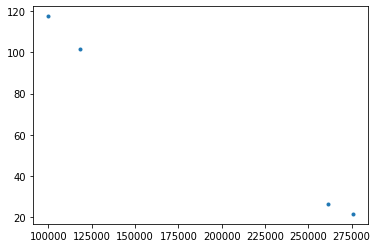

In [89]:
# Define affine mapping from progress variable t to pressure
t2p = lambda t: p1 + t *(p2-p1)
u_out = scipy.integrate.solve_ivp(
  lambda t, u:
    -normals * (p2-p1) \
      * atomics.acousticRI_integrand_scalar(t2p(t), TI, p1, yI, Gamma, physics),
  (0, 1), u1)
plt.plot(t2p(u_out.t), u_out.y.ravel(), '.')
u_out